# Generate report  - POC

## Goal
**WHAT**: Automatic report generation from Hamilton measurements.  
**WHY**: Speed up the report generation, and avoid human errors (copying data, subjective evaluation, ....)

## Tools
Fast iteration in an agile way.  
Generic approach - different plates setup, prameters, ... all with the same code, no changes needed.  

**Python** programming language.  
**jupyter** notebook is currently used, with some functions divided into small modules.  
**Visual Studio Code** IDE (Integrated Development Environment).  
**Markdown** (*.md) format for generated report (Simple, humanly redable).  

## Input:
 - Worklist file path (*.xls) as used for Hamilton input.
   - Sample name
   - Dilution
   - Viscosity
 - Measurement results file path (*.xls) as output from Hamilton.
 - Parameters; constants in code (file path *.json)
   - CV (Coefficient of variation) threshold
   - Referennce value (1.7954e+10 cp/ml)
   - Dilutions [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]
   - Decimal digits for output

## Output:
  - Report (*.md, printable to pdf)
    - Could be manually edited
    - Image files
    - Result sheets
  - Estimated size <2kB (current)

## Done
  - Invalid sample:
    - CV >THRESHOLD
    - Only one point
  - Parameters file (*.scv, *.json)
  - Multiple plates (in worklist file)

## TODO:
  - Modules
  - Finalize the report
  - Running modes
    - Python script - automatic run (command line with parameters)
    - GUI; use modules to crete an App (code remains the same, but used from GUI)
  - Tests (unit, integration)
  - checksum (*.sdax); put into report
  - Extensive testing...
  - Automatic print to *.pdf ?

## Conclusion
End to end evaluation time reduction approximately 2h -> 20min per measurement. (thx Felix)


## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from os import path
import os
from decimal import Decimal
import math

In [2]:
def make_input_paths(input_dir, base_name, sample_num):
    worklist = path.join(input_dir, base_name + 'worklist-ELISA.xls')
    if not os.path.isfile(worklist):
        raise Exception("Worklist file path is invlaid: {}".format(worklist))
    results =  path.join(input_dir, base_name + 'calc{}.xlsx'.format(sample_num))
    if not os.path.isfile(results):
        raise Exception("Rewsults file path is invlaid: {}".format(results))
    
    report = path.join(input_dir, 'results_{}'.format(sample_num))
    report = path.join(report, '{}report_{}.md'.format(base_name, sample_num))

    params = path.join(input_dir, base_name + 'AAV9-ELISA_Parameters.csv')

    return {'worklist': worklist, 'results': results, 'report': report, 'params': params}

In [3]:
WORKING_DIR = './data/input/'
BASE_NAME = '230426_GN004240-033_-_'

## Read data

In [4]:
PLATE_ID = 2 # plate id

input_files = make_input_paths(WORKING_DIR, BASE_NAME, PLATE_ID)
WORKLIST_FILE_PATH = input_files['worklist']
RESULT_FILE_PATH = input_files['results']
REPORT_FILE_PATH = input_files['report']
REPORT_DIR = os.path.dirname(os.path.abspath(REPORT_FILE_PATH))

params = pd.read_csv(input_files['params'], sep=';')
params.set_index('Variable', inplace=True)

data = pd.read_excel(RESULT_FILE_PATH, sheet_name=None)
data["Result_Overview"]

C:\Users\hwn6193\AppData\Roaming\Python\Python39\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Unnamed: 0,Reader Data [cp/ml],Sample Name,Pre-dilution,Result [cp/ml],CV [%],Comment
0,Assay Control,20700000000,Kontrolle,100,2.070000e+12,12.2,NaN
1,Sample 01,6371000000,PPO02_2307HAR_MEG_Z2,100,6.371000e+11,3.8,NaN
2,Sample 02,6874000000,PPO02_2307HAR_MEG_Z3,100,6.874000e+11,9.6,NaN
3,Sample 03,7422000000,PPO02_2307HAR_MEG_Z4,100,7.422000e+11,4.1,NaN
4,Sample 04,12590000000,PPO02_2307HAR_ECV_P,50,6.295000e+11,3.1,NaN
5,Sample 05,26670000000,PPO02_2307_UFA_UF1_R,500,1.333500e+13,5.9,NaN
6,Sample 06,12020000000,PPO02_2307_UFA_Pool,1000,1.202000e+13,7.2,NaN
7,Sample 07,66850000000,PPO02_2307_UCE_P,500,3.342500e+13,6.6,NaN
8,Sample 08,6304000000,PPO02_2307FMB_T03,10,6.304000e+10,10.6,NaN
9,Sample 09,13250000000,PPO02_2307_UFA_Conc,1000,1.325000e+13,6.8,NaN


In [5]:
data["Data"]

,##BLOCKS= 24,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Plate:,Plate01,1.3,PlateFormat,Endpoint,Absorbance,Raw,FALSE,1.0000,NaN,...,12.0000,96.0000,1.0000,8.0000,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Temperature(¡C),1,2,3,4,5,6,7.0000,8.0000,...,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000,10.0000,11.0000,12.0000
2,NaN,26.8,1.4173,1.0025,0.5957,0.3434,1.4833,0.8592,0.4956,0.3078,...,0.0382,0.0378,0.0394,0.0385,0.0377,0.0376,0.0373,0.0376,0.0365,0.0359
3,NaN,NaN,0.6744,0.3738,0.2386,0.1494,0.7202,0.3783,0.2339,0.1390,...,0.0368,0.0362,0.0377,0.0362,0.0369,0.0378,0.0422,0.0419,0.0401,0.0386
4,NaN,NaN,0.6881,0.3836,0.2427,0.1696,1.148,0.6705,0.3803,0.2581,...,0.0372,0.0361,0.0379,0.0375,0.0376,0.0367,0.0425,0.0445,0.0433,0.0391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,Group Summaries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
448,MeanResult_21,NaN,4972000000,Average(Dil.Result),4 significant figures,Scientific Notation,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,CV_21 [%],NaN,7.8,Cv(Dil.Result),1 decimal places,Numeric Notation,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,~End,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = data["Data"]
df_450 = df.iloc[2:10, 2:14].copy().reset_index(drop=True)
df_450.columns = range(df_450.columns.size)
df_450

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.4173,1.0025,0.5957,0.3434,1.4833,0.8592,0.4956,0.3078,0.1886,0.1174,0.0862,0.0464
1,0.6744,0.3738,0.2386,0.1494,0.7202,0.3783,0.2339,0.1390,3.0011,2.4716,2.0474,1.4248
2,0.6881,0.3836,0.2427,0.1696,1.148,0.6705,0.3803,0.2581,3.0725,2.6435,2.3408,1.7180
3,0.7448,0.4405,0.2692,0.1587,1.0765,0.7337,0.4131,0.2505,2.8067,2.4498,2.0751,1.6788
4,1.0996,0.6447,0.3814,0.2413,2.3161,1.6267,1.2390,0.8018,3.1924,2.7574,2.2437,1.6209
5,1.6459,1.12,0.676,0.4203,0.8883,0.4625,0.2925,0.1736,2.7867,2.8694,2.2335,1.6908
6,1.0612,0.5948,0.3667,0.2419,3.4027,3.2504,2.8049,2.4374,3.1459,2.8276,2.1781,1.7567
7,2.3107,1.5667,1.3492,0.8404,2.9575,2.5241,2.1556,1.5844,0.5688,0.3374,0.1963,0.1209


In [7]:
df_630 = df.iloc[2:10, 15:28].copy().reset_index(drop=True)
df_630.columns = range(df_630.columns.size)
df_630

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0399,0.0389,0.0382,0.0378,0.0394,0.0385,0.0377,0.0376,0.0373,0.0376,0.0365,0.0359
1,0.0384,0.0384,0.0368,0.0362,0.0377,0.0362,0.0369,0.0378,0.0422,0.0419,0.0401,0.0386
2,0.0367,0.0373,0.0372,0.0361,0.0379,0.0375,0.0376,0.0367,0.0425,0.0445,0.0433,0.0391
3,0.0379,0.0378,0.0375,0.0370,0.0384,0.0387,0.0375,0.0372,0.0417,0.0407,0.0411,0.0376
4,0.0386,0.0379,0.0375,0.0368,0.0443,0.0393,0.0385,0.0383,0.0464,0.0412,0.0409,0.0390
5,0.0399,0.0389,0.0378,0.0378,0.0377,0.0383,0.0366,0.0364,0.0439,0.0424,0.0406,0.0394
6,0.0383,0.0372,0.0368,0.0365,0.0445,0.0430,0.0431,0.0407,0.0419,0.0415,0.0407,0.0397
7,0.0422,0.0399,0.0397,0.0388,0.0414,0.0415,0.0409,0.0397,0.0378,0.0364,0.0375,0.0360


In [8]:
def get_data_crop(df, row_span, col_span):
  crop = df.iloc[row_span, col_span].copy()
  crop.reset_index(drop=True, inplace=True)
  crop.set_index([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']], inplace=True)
  crop.columns = range(1, crop.columns.size+1)
  return crop

def read_data_xls(file_path):
  data = pd.read_excel(file_path, sheet_name=None)
  df_450 = get_data_crop(data["Data"], range(2, 10), range(2, 14))
  df_630 = get_data_crop(data["Data"], range(2, 10), range(15, 27))

  return df_450, df_630


df_450, df_630 = read_data_xls(RESULT_FILE_PATH)

C:\Users\hwn6193\AppData\Roaming\Python\Python39\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [9]:
df_delta = df_450 - df_630
df_delta

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.3774,0.9636,0.5575,0.3056,1.4439,0.8207,0.4579,0.2702,0.1513,0.0798,0.0497,0.0105
B,0.636,0.3354,0.2018,0.1132,0.6825,0.3421,0.1970,0.1012,2.9589,2.4297,2.0073,1.3862
C,0.6514,0.3463,0.2055,0.1335,1.1101,0.633,0.3427,0.2214,3.0300,2.5990,2.2975,1.6789
D,0.7069,0.4027,0.2317,0.1217,1.0381,0.695,0.3756,0.2133,2.7650,2.4091,2.0340,1.6412
E,1.061,0.6068,0.3439,0.2045,2.2718,1.5874,1.2005,0.7635,3.1460,2.7162,2.2028,1.5819
F,1.606,1.0811,0.6382,0.3825,0.8506,0.4242,0.2559,0.1372,2.7428,2.8270,2.1929,1.6514
G,1.0229,0.5576,0.3299,0.2054,3.3582,3.2074,2.7618,2.3967,3.1040,2.7861,2.1374,1.7170
H,2.2685,1.5268,1.3095,0.8016,2.9161,2.4826,2.1147,1.5447,0.5310,0.3010,0.1588,0.0849


In [10]:
def to_multi_index(df_single_index, name):
  df_multi_idx = df_single_index.stack().to_frame()
  df_multi_idx.columns = [name]

  return df_multi_idx


In [11]:
def read_concat_data(data_file_path):
  df_450, df_630 = read_data_xls(data_file_path)
  df_delta = df_450 - df_630
  df_delta_all = to_multi_index(df_delta, "OD_delta")
  df_450_all = to_multi_index(df_450, "OD_450")
  df_630_all = to_multi_index(df_630, "OD_630")

  return pd.merge(df_delta_all, 
                  pd.merge(df_450_all, df_630_all, 
                  left_index=True, right_index=True),
                  left_index=True, right_index=True)

In [12]:
m = read_concat_data(RESULT_FILE_PATH)
m

C:\Users\hwn6193\AppData\Roaming\Python\Python39\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


OD_delta  OD_450  OD_630
A 1    1.3774  1.4173  0.0399
  2    0.9636  1.0025  0.0389
  3    0.5575  0.5957  0.0382
  4    0.3056  0.3434  0.0378
  5    1.4439  1.4833  0.0394
...       ...     ...     ...
H 8    1.5447  1.5844  0.0397
  9     0.531  0.5688  0.0378
  10    0.301  0.3374  0.0364
  11   0.1588  0.1963  0.0375
  12   0.0849  0.1209   0.036

[96 rows x 3 columns]

### Layouts

First read layouts as arrays and re-arage to dataframe, using plate layout indexing.

In [13]:
def to_matrix(l, n):
  return [l[i:i+n] for i in range(0, len(l), n)]

def index_plate_layout(plate_layout):
  plate_layout.set_index([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']], inplace=True)
  plate_layout.columns = range(1, plate_layout.columns.size + 1)

  return plate_layout

def to_plate_layout(lst):
  l_2d = to_matrix(lst, 8)
  plate_layout = pd.DataFrame(l_2d).T
  
  return index_plate_layout(plate_layout)

In [14]:
import data.layouts as layouts
to_plate_layout(layouts.l_plate_layout)

,1,2,3,4,5,6,7,8,9,10,11,12
A,k_1,k_2,k_3,k_4,r1_1,r2_1,r3_1,r4_1,r5_1,r6_1,r7_1,b
B,s1_1,s1_2,s1_3,s1_4,s8_1,s8_2,s8_3,s8_4,s15_1,s15_2,s15_3,s15_4
C,s2_1,s2_2,s2_3,s2_4,s9_1,s9_2,s9_3,s9_4,s16_1,s16_2,s16_3,s16_4
D,s3_1,s3_2,s3_3,s3_4,s10_1,s10_2,s10_3,s10_4,s17_1,s17_2,s17_3,s17_4
E,s4_1,s4_2,s4_3,s4_4,s11_1,s11_2,s11_3,s11_4,s18_1,s18_2,s18_3,s18_4
F,s5_1,s5_2,s5_3,s5_4,s12_1,s12_2,s12_3,s12_4,s19_1,s19_2,s19_3,s19_4
G,s6_1,s6_2,s6_3,s6_4,s13_1,s13_2,s13_3,s13_4,s20_1,s20_2,s20_3,s20_4
H,s7_1,s7_2,s7_3,s7_4,s14_1,s14_2,s14_3,s14_4,s21_1,s21_2,s21_3,s21_4


Save layouts to CSV, so that ib the future a layout could be defined in i.e. Excel.

In [15]:
def save_plate_layout_csv(layout_list, out_file):
  l = to_plate_layout(layout_list)
  l.to_csv(out_file, index=False)

SAVE_LAYOUTS_CSV = False
if SAVE_LAYOUTS_CSV:
  save_plate_layout_csv(layouts.l_plate_layout, './data/plate_layout.csv')
  save_plate_layout_csv(layouts.l_plate_layout_ident, './data/plate_layout_ident.csv')
  save_plate_layout_csv(layouts.l_plate_layout_num, './data/plate_layout_num.csv')
  save_plate_layout_csv(layouts.l_plate_layout_dil_id, './data/plate_layout_dil_id.csv')


Read CSV layout for check

In [16]:
def read_plate_layout(file_path):
  plate_layout = pd.read_csv(file_path)
  index_plate_layout(plate_layout)

  return plate_layout

plate_layout = read_plate_layout('./data/plate_layout.csv')
plate_layout_id = read_plate_layout('./data/plate_layout_ident.csv')
plate_layout_num = read_plate_layout('./data/plate_layout_num.csv')
plate_layout_dil_id = read_plate_layout('./data/plate_layout_dil_id.csv')

In [17]:
display(plate_layout_id)
display(plate_layout_num)
display(plate_layout_dil_id)

,1,2,3,4,5,6,7,8,9,10,11,12
A,k,k,k,k,r,r,r,r,r,r,r,b
B,s,s,s,s,s,s,s,s,s,s,s,s
C,s,s,s,s,s,s,s,s,s,s,s,s
D,s,s,s,s,s,s,s,s,s,s,s,s
E,s,s,s,s,s,s,s,s,s,s,s,s
F,s,s,s,s,s,s,s,s,s,s,s,s
G,s,s,s,s,s,s,s,s,s,s,s,s
H,s,s,s,s,s,s,s,s,s,s,s,s


,1,2,3,4,5,6,7,8,9,10,11,12
A,1,1,1,1,1,1,1,1,1,1,1,0
B,1,1,1,1,8,8,8,8,15,15,15,15
C,2,2,2,2,9,9,9,9,16,16,16,16
D,3,3,3,3,10,10,10,10,17,17,17,17
E,4,4,4,4,11,11,11,11,18,18,18,18
F,5,5,5,5,12,12,12,12,19,19,19,19
G,6,6,6,6,13,13,13,13,20,20,20,20
H,7,7,7,7,14,14,14,14,21,21,21,21


,1,2,3,4,5,6,7,8,9,10,11,12
A,1,2,3,4,1,2,3,4,5,6,7,0
B,1,2,3,4,1,2,3,4,1,2,3,4
C,1,2,3,4,1,2,3,4,1,2,3,4
D,1,2,3,4,1,2,3,4,1,2,3,4
E,1,2,3,4,1,2,3,4,1,2,3,4
F,1,2,3,4,1,2,3,4,1,2,3,4
G,1,2,3,4,1,2,3,4,1,2,3,4
H,1,2,3,4,1,2,3,4,1,2,3,4


### Combine read data from XLSX with layouts

In [18]:
def concat_data_and_layout(df_data, df_layout):
  return pd.merge(df_data, df_layout,
                  left_index=True, right_index=True)

# df_all = concat_data_and_layout(m, to_multi_index(plate_layout, 'plate_layout'))
df_all = concat_data_and_layout(m, to_multi_index(plate_layout_id, 'plate_layout_ident'))
df_all = concat_data_and_layout(df_all, to_multi_index(plate_layout_num, 'plate_layout_num'))
df_all = concat_data_and_layout(df_all, to_multi_index(plate_layout_dil_id, 'plate_layout_dil_id'))
display(df_all)

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 1    1.3774  1.4173  0.0399                  k                 1  \
  2    0.9636  1.0025  0.0389                  k                 1   
  3    0.5575  0.5957  0.0382                  k                 1   
  4    0.3056  0.3434  0.0378                  k                 1   
  5    1.4439  1.4833  0.0394                  r                 1   
...       ...     ...     ...                ...               ...   
H 8    1.5447  1.5844  0.0397                  s                14   
  9     0.531  0.5688  0.0378                  s                21   
  10    0.301  0.3374  0.0364                  s                21   
  11   0.1588  0.1963  0.0375                  s                21   
  12   0.0849  0.1209   0.036                  s                21   

      plate_layout_dil_id  
A 1                     1  
  2                     2  
  3                     3  
  4                     4  
  5                     1  
...                   ...  
H 8                     4  
  9                     1  
  10                    2  
  11                    3  
  12                    4  

[96 rows x 6 columns]

Filter data

In [19]:
display(df_all.loc[(df_all['plate_layout_ident']=='r')])

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 5    1.4439  1.4833  0.0394                  r                 1  \
  6    0.8207  0.8592  0.0385                  r                 1   
  7    0.4579  0.4956  0.0377                  r                 1   
  8    0.2702  0.3078  0.0376                  r                 1   
  9    0.1513  0.1886  0.0373                  r                 1   
  10   0.0798  0.1174  0.0376                  r                 1   
  11   0.0497  0.0862  0.0365                  r                 1   

      plate_layout_dil_id  
A 5                     1  
  6                     2  
  7                     3  
  8                     4  
  9                     5  
  10                    6  
  11                    7

In [20]:
def get_sample(dfa, type, sample_num):
    # TODO: check for valid `type` `and sample_num`
    dfa = dfa.loc[(dfa['plate_layout_ident']==type) & (dfa['plate_layout_num']==sample_num)]
    return dfa

# type ['k', 'b', 's']
# sample_num [1:21, 'b']
display(get_sample(df_all, 's', 1))

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
B 1    0.636  0.6744  0.0384                  s                 1  \
  2   0.3354  0.3738  0.0384                  s                 1   
  3   0.2018  0.2386  0.0368                  s                 1   
  4   0.1132  0.1494  0.0362                  s                 1   

     plate_layout_dil_id  
B 1                    1  
  2                    2  
  3                    3  
  4                    4

### Dilution to Concentration

Define dilution dataframe. The dataframe is indexed according plate layout, index of refference dataframe corresponds to refference of the `plate_layout_dil`.

In [21]:
# TODO: read reference value from parameters
REF_VAL_MAX = 1.7954e+10
DILUTIONS = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0]

def make_concentration(ref_val_max, dilution):
    conc  = pd.DataFrame({'dilution': dilution})
    conc.loc[:, ['concentration']] = conc.apply(lambda x: ref_val_max / x['dilution'], axis=1)
    conc.index = range(1, len(dilution) + 1)
    return conc

reference_conc = make_concentration(REF_VAL_MAX, DILUTIONS)
display(reference_conc)

,dilution,concentration
1,1.0,1.795400e+10
2,2.0,8.977000e+09
3,4.0,4.488500e+09
4,8.0,2.244250e+09
5,16.0,1.122125e+09
6,32.0,5.610625e+08
7,64.0,2.805312e+08


Check the `reference_set_conc` indexing

In [22]:
print(reference_conc.loc[1])
print(reference_conc.loc[7])

dilution         1.000000e+00
concentration    1.795400e+10
Name: 1, dtype: float64
dilution                64.0
concentration    280531250.0
Name: 7, dtype: float64


## Fit

In [23]:
import fitdata
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import OptimizeWarning

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', OptimizeWarning)

### Get the fitting data from dataframe

In [24]:
ref = df_all.loc[(df_all['plate_layout_ident']=='r')].copy()
ref['plate_layout_dil'] = ref['plate_layout_dil_id'].map(reference_conc['concentration'])
display(ref)

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 5    1.4439  1.4833  0.0394                  r                 1  \
  6    0.8207  0.8592  0.0385                  r                 1   
  7    0.4579  0.4956  0.0377                  r                 1   
  8    0.2702  0.3078  0.0376                  r                 1   
  9    0.1513  0.1886  0.0373                  r                 1   
  10   0.0798  0.1174  0.0376                  r                 1   
  11   0.0497  0.0862  0.0365                  r                 1   

      plate_layout_dil_id  plate_layout_dil  
A 5                     1      1.795400e+10  
  6                     2      8.977000e+09  
  7                     3      4.488500e+09  
  8                     4      2.244250e+09  
  9                     5      1.122125e+09  
  10                    6      5.610625e+08  
  11                    7      2.805312e+08

### Fit with confidence interval

In [25]:
CONFIDENCE_INTERVAL = 95.0 # 95% confidence interval = 100*(1-alpha)

In [26]:
from scipy.stats import distributions

def fit_image(x, y, popt, pcov, file_path, confidence_interval=CONFIDENCE_INTERVAL,
    confidence=None, interval_ratio=2.0,
    rm_index=[],
    sx=None, sy=None, mask_index=[], sna_idx=[],
    verbose=False, valid_sample=True, show=True):
    r"""Plot the fitted function with confidence intervals.

    Confidence intervals coud be set using `confidence` parameter.
    'student-t' method is a correct one producing wider confidence intervals.

    Parameters
    ----------
    x : array_like
        x-axis reference values.
    y : array_like
        y-axis reference values.
    popt : iterable
        Fit parameters.
    pcov : 
        Covariance matrix from fitting algorithm.
    file_path : string
        Path where the graph image is saved or `None`
    confidence_interval : float 
        Confidence interval in %
    interval_ratio: float
        Ration of min and max extention of x axis for fitted curve plot.
    rm_index: list
        Index of a removed point.
    sx : array_like
        Sample x-values.
    sy : array_like
        Sample x-values.
    mask_index : array_like
        Indices of masked samples.
    verbose : bool
        Print verbose output.
    show : bool
        Show the graph. If `False` image is saved if file path is given. 
    """

    # confidence [None, 'student-t', 'sqrt_err'] 
    if verbose:
        print('parameter', popt)
    perr = np.sqrt(np.diag(pcov))
    sigma_err = 1.0
    chisq = np.sum((perr / sigma_err) ** 2)
    if verbose:
        print('chisq={0:.4}; error={1}'.format(np.sqrt(chisq), perr))
        # print('function calls', infodict['nfev'])

    kwargs = { 'marker': 'x'}
    if not valid_sample:
        kwargs = { 'marker': 'o', 'facecolors':'none'}
    if (sx is not None) and (sy is not None):
        if len(sx.drop(mask_index, axis=0)) != 0:
            plt.scatter(sx.drop(mask_index, axis=0), sy.drop(mask_index, axis=0),
                        s=48, linewidths=0.6, label='sample valid', color='forestgreen', **kwargs)
        if (len(sx.iloc[mask_index]) != 0) and (list(mask_index) != list(sna_idx)):
            plt.scatter(sx.iloc[mask_index], sy.iloc[mask_index],
                        s=48, linewidths=0.8, label='sample masked', color='r', **kwargs)

    if len(x.drop(rm_index, axis=0)) != 0:
        plt.scatter(x.drop(rm_index, axis=0), y.drop(rm_index, axis=0), marker='+',
                color='royalblue', s=48, linewidths=0.8, label='reference')
    if len(x.iloc[rm_index]) != 0:
        plt.scatter(x.iloc[rm_index], y.iloc[rm_index], marker='.',
                color='r', s=48, linewidths=0.8, label='reference masked')
    plt.xscale('log')
    
    alpha = (100.0 - confidence_interval) / 100.0 
    n = len(y)    # number of data points
    p = len(popt) # number of parameters
    dof = max(0, n - p) # number of degrees of freedom

    # student-t value for the dof and confidence level
    tval = distributions.t.ppf(1.0 - alpha / 2., dof) 
    sigma_popt = np.empty(len(popt), dtype=np.float64)
    param_names = ['a', 'b', 'c', 'd']
    for i, p, var, pname in zip(range(n), popt, np.diag(pcov), param_names):
        sigma = var ** 0.5
        st = sigma * tval
        sigma_popt[i] = st
        if verbose:
            print('{0}: {1:.3} [{2:.3}, {3:.3}]; err={4:.3}[{5:.2f}%]'.format(pname, p, p - st, p + st, st, 100*st/p))

    if confidence=='None' or confidence=='student-t':
        if verbose: print('student-t is used for error estimation using {} degrees of freedom'.format(dof))
        popt_high = popt + sigma_popt
        popt_low = popt - sigma_popt
    else:
        if verbose: print('sqrt of covariance matrix diagonal is used for error estimation')
        popt_high = popt + perr
        popt_low = popt - perr

    num_pts = 100
    x_min = x.min()
    x_max = x.max()
    t = np.arange(x_min, x_max, (x_max - x_min) / num_pts)
    plt.plot(t, fitdata.func(t, *popt), color='slategray', linewidth=0.2)

    sx_n = sx[~sx.isna()] if sx is not None else None
    x_min_ext = x.min() / interval_ratio
    if sx is not None: x_min_ext = min(x_min_ext, sx_n.min())
    if x_min != x_min_ext:
        t = np.arange(x_min_ext, x_min, (x_min - x_min_ext) / (num_pts / 10.0))
        plt.plot(t, fitdata.func(t, *popt), color='red', linestyle=(0, (5, 10)), linewidth=0.2, label='ext')

    x_max_ext = x.max() * interval_ratio
    if sx is not None: x_max_ext = max(x_max_ext, sx_n.max())
    if x_max != x_max_ext:
        t = np.arange(x_max, x_max_ext, (x_max_ext - x_max) / (num_pts / 10.0))
        # no label, only one extension labe
        plt.plot(t, fitdata.func(t, *popt), color='red', linestyle=(0, (5, 10)), linewidth=0.2)

    # show NaN concentration values somewhere -> show OD
    sx_na = sx[sx.isna()] if sx is not None else None
    if sx is not None:
        if verbose: print("NaN indices:", sx_na.index)
        sna_idx = sx[~sx.isna()].index
        if len(sx_na) != 0:
            x_na = np.full(shape=len(sx_na), fill_value=x_min_ext * 0.5)
            y_na = sy.drop(sna_idx, axis=0)
            plt.scatter(x_na, y_na, marker='_', color='red', s=48, linewidths=0.8, label='backfit failed')

    plt.xlabel('concentration [cp/ml]')
    plt.ylabel('Optical density')

    bound_upper = fitdata.func(t, *popt_high)
    bound_lower = fitdata.func(t, *popt_low)
    # plotting the confidence intervals
    plt.fill_between(t, bound_lower, bound_upper,
                    color = 'black', alpha = 0.15)
    
    plt.legend()

    if file_path is not None:
         plt.savefig(file_path)
    if show:
        plt.show()
    else:
        plt.clf()

In [27]:
def fit_sheet(popt, pcov, n, confidence_interval=95.0):
    # `confidence_interval` 95% confidence interval = 100*(1-alpha)
    alpha = (100.0 - confidence_interval) / 100.0 
    p = len(popt) # number of parameters
    dof = max(0, n - p) # number of degrees of freedom

    # student-t value for the dof and confidence level
    tval = distributions.t.ppf(1.0 - alpha / 2.0, dof) 

    sigma_popt = np.empty(len(popt), dtype=np.float64)
    confidence_interval = [None] * 4
    for i, p, var in zip(range(n), popt, np.diag(pcov)):
        sigma = var ** 0.5
        st = sigma * tval
        sigma_popt[i] = st
        confidence_interval[i] = '[{0:.3}, {1:.3}]'.format(p - st, p + st)

    param_names = ['a', 'b', 'c', 'd']
    perr = np.sqrt(np.diag(pcov))

    return pd.DataFrame({'Parameter name': param_names, 'Estimated value':popt,
        'Error': perr, 'Confidence interval': confidence_interval})

Backfit

In [28]:
def backfit(df, param):
    bf = df[['OD_delta', 'plate_layout_dil']].copy()
    bf = bf.reindex(['plate_layout_dil', 'OD_delta'], axis=1)
    bf.rename(columns={'plate_layout_dil': 'Standard Value [cp/ml]', 'OD_delta': 'Optical density'}, inplace=True)
    bf.loc[:, ['Concentration backfit [cp/ml]']] = bf.apply(lambda x: fitdata.inv_func(x['Optical density'], *param), axis=1)
    bf.loc[:, ['SV to OD fit']] = bf.apply(lambda x: fitdata.func(x['Standard Value [cp/ml]'], *param), axis=1)
    bf.index.name = 'Well'
    bf = bf.reindex(['Standard Value [cp/ml]', 'Concentration backfit [cp/ml]', 'Optical density', 'SV to OD fit'], axis=1)
    bf.loc[:, ['Recovery rate [%]']] = bf.apply(lambda x: (x['Concentration backfit [cp/ml]'] / x['Standard Value [cp/ml]']) * 100.0, axis=1)
    
    return bf

In [29]:
def fit_reference_auto_rm(x, y, err_threshold=0.998, verbose=False):
    """Fits the reference and removes a point to fing min error

    Parameters
    ----------
    x : array_like
        x-axis values.
    y : array_like
        y-axis value.
    err_threshold : Eroor threshold to to skip point removal

    Returns
    -------
    array
        parameters of the filt
    int
        index of the removed point, -1 if no point is removed
    float64
        error
    """
    # fc = fitdata.fit_reference(fitdata.func, x, y)
    fit_stats = pd.DataFrame(columns=['idx', 'metric', 'note'])
    fc = None
    try:
        fc = fitdata.fit_reference(fitdata.func, x, y)
    except Exception as e:
        estr = '{0}, {1} Reason: {2}'.format(np.nan, -1, str(e))
        if verbose: print(e)

    idx = []
    r2_max = 0.0
    if fc:
        bfn = lambda l: fitdata.inv_func(l, *fc[0])
        x_hat = bfn(y)
        r2_max = r2_score(x, x_hat)

    if verbose:
        print('R-squared is invalid for nonlinear models!')
        print('metric, index')
        print('{0:.5f}, {1}'.format(r2_max, idx))
    
    if r2_max > err_threshold :
        fit_stats.loc[len(fit_stats)] = [-1, r2_max, '']
        return fc, idx, r2_max, fit_stats
    elif r2_max == 0.0:
        fit_stats.loc[len(fit_stats)] = [-1, np.nan, '']
    else:
        fit_stats.loc[len(fit_stats)] = [-1, r2_max, 'metric < threshold ({:.4f} < {:.4f})'.format(r2_max, err_threshold)]

    for i in range(len(x)):
        xd = x.drop([i], axis=0)
        yd = y.drop([i], axis=0)
        try:
            fc_i = fitdata.fit_reference(fitdata.func, xd.to_numpy(), yd.to_numpy())
        except Exception as e:
            estr = '{0}, {1} Reason: {2}'.format(np.nan, [i], str(e))
            if verbose: print(e)
            fit_stats.loc[len(fit_stats)] = [i, np.nan, str(e)]
            continue

        bfn = lambda l: fitdata.inv_func(l, *fc_i[0])
        x_hat = bfn(yd)
        r_squared = r2_score(xd, x_hat)
        if np.isinf(fc_i[1]).any():
            fit_stats.loc[len(fit_stats)] = [i, r_squared, 'Invalid covariance matrix.']
            continue

        fit_stats.loc[len(fit_stats)] = [i, r_squared, '']
        if verbose: print('{0:.4f}, {1}'.format(r_squared, i))
        if (r_squared > r2_max) and not np.isinf(fc_i[1]).any():
            r2_max = r_squared
            fc = fc_i
            idx = [i]

    fit_stats.set_index('idx', inplace=True)
    fit_stats.loc[idx, 'note'] = 'Maximum.'

    return fc, idx, r2_max, fit_stats

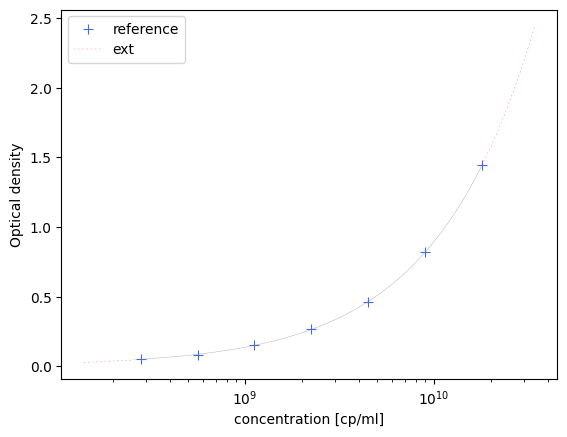

,idx,metric,note
0,-1,0.999945,


[]

In [30]:
x = ref.reset_index(level=[0,1])['plate_layout_dil']
y = ref.reset_index(level=[0,1])['OD_delta']
fit_result = fit_reference_auto_rm(x, y, verbose=False)
popt = fit_result[0][0]
pcov = fit_result[0][1]

fit_image(x, y, fit_result[0][0], fit_result[0][1], None, confidence='student-t', rm_index=fit_result[1])
display(fit_result[3])
display(fit_result[1])

In [31]:
bf = backfit(ref, popt)
display(bf)

od_min = bf['Optical density'].min()
od_max = bf['Optical density'].max()
print('Optical density range <{0:.4f}, {1:.4f}>'.format(od_min, od_max))

od_fit_min = bf['SV to OD fit'].min()
od_fit_max = bf['SV to OD fit'].max()
print('SV to OD fit range <{0:.4f}, {1:.4f}>'.format(od_fit_min, od_fit_max))

sv_min = bf['Standard Value [cp/ml]'].min()
sv_max = bf['Standard Value [cp/ml]'].max()
print('Standard Value [cp/ml] range <{0}, {1}>'.format(sv_min, sv_max))

cb_min = bf['Concentration backfit [cp/ml]'].min()
cb_max = bf['Concentration backfit [cp/ml]'].max()
print('Concentration backfit [cp/ml] range <{0}, {1}>'.format(cb_min, cb_min))

Standard Value [cp/ml]  Concentration backfit [cp/ml] Optical density   
A 5             1.795400e+10                   1.795329e+10          1.4439  \
  6             8.977000e+09                   9.000289e+09          0.8207   
  7             4.488500e+09                   4.411274e+09          0.4579   
  8             2.244250e+09                   2.314879e+09          0.2702   
  9             1.122125e+09                   1.138759e+09          0.1513   
  10            5.610625e+08                   5.199381e+08          0.0798   
  11            2.805312e+08                   2.905455e+08          0.0497   

      SV to OD fit  Recovery rate [%]  
A 5       1.443946          99.996066  
  6       0.818962         100.259434  
  7       0.464449          98.279469  
  8       0.263439         103.147130  
  9       0.149492         101.482339  
  10      0.084908          92.670267  
  11      0.048304         103.569733

Optical density range <0.0497, 1.4439>
SV to OD fit range <0.0483, 1.4439>
Standard Value [cp/ml] range <280531250.0, 17954000000.0>
Concentration backfit [cp/ml] range <290545466.66074324, 290545466.66074324>


## Sample evaluation

In [32]:
display(get_sample(df_all, 's', 1))

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
B 1    0.636  0.6744  0.0384                  s                 1  \
  2   0.3354  0.3738  0.0384                  s                 1   
  3   0.2018  0.2386  0.0368                  s                 1   
  4   0.1132  0.1494  0.0362                  s                 1   

     plate_layout_dil_id  
B 1                    1  
  2                    2  
  3                    3  
  4                    4

Fit the data, and apply the inverse function as a check...

In [33]:
samplesk = df_all.loc[(df_all['plate_layout_ident']=='s') | (df_all['plate_layout_ident']=='k') | (df_all['plate_layout_ident']=='r')]
samplesk.loc[:, ['plate_layout_dil']] = samplesk['plate_layout_dil_id'].map(reference_conc['dilution'])
display(samplesk)

def unique_sample_numbers(df):
  sample_nums = df['plate_layout_num'].astype(int).unique()
  sample_nums.sort()
  return sample_nums

sample_nums = unique_sample_numbers(samplesk)
display(sample_nums)

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 1    1.3774  1.4173  0.0399                  k                 1  \
  2    0.9636  1.0025  0.0389                  k                 1   
  3    0.5575  0.5957  0.0382                  k                 1   
  4    0.3056  0.3434  0.0378                  k                 1   
  5    1.4439  1.4833  0.0394                  r                 1   
...       ...     ...     ...                ...               ...   
H 8    1.5447  1.5844  0.0397                  s                14   
  9     0.531  0.5688  0.0378                  s                21   
  10    0.301  0.3374  0.0364                  s                21   
  11   0.1588  0.1963  0.0375                  s                21   
  12   0.0849  0.1209   0.036                  s                21   

      plate_layout_dil_id  plate_layout_dil  
A 1                     1               1.0  
  2                     2               2.0  
  3                     3               4.0  
  4                     4               8.0  
  5                     1               1.0  
...                   ...               ...  
H 8                     4               8.0  
  9                     1               1.0  
  10                    2               2.0  
  11                    3               4.0  
  12                    4               8.0  

[95 rows x 7 columns]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

For Coefficient of variation compution we need to use ddof (degrees of freedom) parameter set to `ddof=1`.

In [34]:
from scipy.stats import variation
import numpy

def conc_func(x, dil, *popt):
    return fitdata.inv_func(x, *popt) * dil


# process sample
sample_num_t = 11
sample_type_t = 's'
a_sample = get_sample(samplesk, sample_type_t, sample_num_t)
a_sample.loc[:, ['concentration']] = a_sample.apply(lambda x: conc_func(x['OD_delta'], x['plate_layout_dil'], *popt), axis=1)
display(a_sample)

smp_t = a_sample[~a_sample.concentration.isna()]
display(smp_t)
test_cv = variation(smp_t['concentration'], ddof=1)
test_mean = numpy.mean(smp_t['concentration'])
print("CV %f" % test_cv)
print("mean %f" % test_mean)

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
E 5   2.2718  2.3161  0.0443                  s                11  \
  6   1.5874  1.6267  0.0393                  s                11   
  7   1.2005   1.239  0.0385                  s                11   
  8   0.7635  0.8018  0.0383                  s                11   

     plate_layout_dil_id  plate_layout_dil  concentration  
E 5                    1               1.0   3.125053e+10  
  6                    2               2.0   4.031660e+10  
  7                    3               4.0   5.730537e+10  
  8                    4               8.0   6.591789e+10

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
E 5   2.2718  2.3161  0.0443                  s                11  \
  6   1.5874  1.6267  0.0393                  s                11   
  7   1.2005   1.239  0.0385                  s                11   
  8   0.7635  0.8018  0.0383                  s                11   

     plate_layout_dil_id  plate_layout_dil  concentration  
E 5                    1               1.0   3.125053e+10  
  6                    2               2.0   4.031660e+10  
  7                    3               4.0   5.730537e+10  
  8                    4               8.0   6.591789e+10

CV 0.323660
mean 48697594964.885971


### Compute concentration for all `s` and `k` samples

In [35]:
samplesk.loc[:, ['concentration']] = samplesk.apply(lambda x: conc_func(x['OD_delta'], x['plate_layout_dil'], *popt), axis=1)
samplesk.loc[:, ['backfit']] = samplesk.apply(lambda x: fitdata.inv_func(x['OD_delta'], *popt), axis=1)
samplesk

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 1    1.3774  1.4173  0.0399                  k                 1  \
  2    0.9636  1.0025  0.0389                  k                 1   
  3    0.5575  0.5957  0.0382                  k                 1   
  4    0.3056  0.3434  0.0378                  k                 1   
  5    1.4439  1.4833  0.0394                  r                 1   
...       ...     ...     ...                ...               ...   
H 8    1.5447  1.5844  0.0397                  s                14   
  9     0.531  0.5688  0.0378                  s                21   
  10    0.301  0.3374  0.0364                  s                21   
  11   0.1588  0.1963  0.0375                  s                21   
  12   0.0849  0.1209   0.036                  s                21   

      plate_layout_dil_id  plate_layout_dil  concentration       backfit  
A 1                     1               1.0   1.694769e+10  1.694769e+10  
  2                     2               2.0   2.190199e+10  1.095099e+10  
  3                     3               4.0   2.244314e+10  5.610784e+09  
  4                     4               8.0   2.152736e+10  2.690920e+09  
  5                     1               1.0   1.795329e+10  1.795329e+10  
...                   ...               ...            ...           ...  
H 8                     4               8.0   1.559785e+11  1.949732e+10  
  9                     1               1.0   5.286594e+09  5.286594e+09  
  10                    2               2.0   5.282967e+09  2.641483e+09  
  11                    3               4.0   4.832934e+09  1.208233e+09  
  12                    4               8.0   4.488000e+09  5.609999e+08  

[95 rows x 9 columns]

### Sample masking

In [36]:
def mask_reason_fn(val, odmin, odmax, note):
    if val < odmin:
        return '{2} {0:.3e} < {1:.3e}'.format(Decimal(val), Decimal(odmin), note)
    if val > odmax:
        return '{2} {0:.3e} > {1:.3e}'.format(Decimal(val), Decimal(odmin), note)
    if math.isnan(val):
        return 'NaN'
    return None

def mask_reason_short_fn(val, vmin, vmax, dil, note):
    if val < vmin:
        return '<{:.3e}'.format(Decimal(vmin * dil))
    if val > vmax:
        return '>{:.3e}'.format(Decimal(vmax * dil))
    if math.isnan(val):
        return 'Backfit failed.'
    return None

print('Optical density range = <{0:.4f}, {1:.4f}>'.format(od_min, od_max))
print('Backfit range = <{0:.4e}, {1:.4e}>'.format(Decimal(sv_min), sv_max))
od_note = 'Measured OD'
samplesk.loc[:, ['od_mask_reason']] = samplesk.apply(lambda x: mask_reason_fn(x['OD_delta'], od_min, od_max, od_note), axis=1)
sv_note = 'Backfit'
samplesk.loc[:, ['mask_reason']] = samplesk.apply(lambda x: mask_reason_short_fn(x['backfit'], cb_min, cb_max, x['plate_layout_dil'], ''), axis=1)
samplesk

Optical density range = <0.0497, 1.4439>
Backfit range = <2.8053e+8, 1.7954e+10>


OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
A 1    1.3774  1.4173  0.0399                  k                 1  \
  2    0.9636  1.0025  0.0389                  k                 1   
  3    0.5575  0.5957  0.0382                  k                 1   
  4    0.3056  0.3434  0.0378                  k                 1   
  5    1.4439  1.4833  0.0394                  r                 1   
...       ...     ...     ...                ...               ...   
H 8    1.5447  1.5844  0.0397                  s                14   
  9     0.531  0.5688  0.0378                  s                21   
  10    0.301  0.3374  0.0364                  s                21   
  11   0.1588  0.1963  0.0375                  s                21   
  12   0.0849  0.1209   0.036                  s                21   

      plate_layout_dil_id  plate_layout_dil  concentration       backfit   
A 1                     1               1.0   1.694769e+10  1.694769e+10  \
  2                     2               2.0   2.190199e+10  1.095099e+10   
  3                     3               4.0   2.244314e+10  5.610784e+09   
  4                     4               8.0   2.152736e+10  2.690920e+09   
  5                     1               1.0   1.795329e+10  1.795329e+10   
...                   ...               ...            ...           ...   
H 8                     4               8.0   1.559785e+11  1.949732e+10   
  9                     1               1.0   5.286594e+09  5.286594e+09   
  10                    2               2.0   5.282967e+09  2.641483e+09   
  11                    3               4.0   4.832934e+09  1.208233e+09   
  12                    4               8.0   4.488000e+09  5.609999e+08   

                       od_mask_reason mask_reason  
A 1                              None        None  
  2                              None        None  
  3                              None        None  
  4                              None        None  
  5                              None        None  
...                               ...         ...  
H 8   Measured OD 1.545e+0 > 4.970e-2  >1.436e+11  
  9                              None        None  
  10                             None        None  
  11                             None        None  
  12                             None        None  

[95 rows x 11 columns]

In [37]:
SAMPLE_TYPES = {'s':'sample', 'k':'controll', 'r':'refference', 'b':'blank'}

def process_sample(samples, stype, sample_num):
    sample = get_sample(samples, stype, sample_num)
    smp_t = sample[sample.mask_reason.isna()]
    cv = np.nan
    mean = np.nan
    if len(smp_t['concentration']) > 1:
        cv = variation(smp_t['concentration'], ddof=1)
        mean = numpy.mean(smp_t['concentration'])
    elif len(smp_t['concentration']) == 1:
        mean = numpy.mean(smp_t['concentration'])

    return sample, cv, mean


CV_THRESHOLD = 0.2 # 20%
MIN_VALID_SAMPLE_POINTS = 2

def sample_check(samples, stype, sample_num, cv_thresh=CV_THRESHOLD,
                 min_valid_pts=MIN_VALID_SAMPLE_POINTS):
    s = process_sample(samples, stype, sample_num)
    valid = True
    note = ''
    if s[1] > cv_thresh:
        note = 'CV > {}; '.format(cv_thresh)
        valid = False
    smp = s[0]
    valid_pts = smp['mask_reason'].isna().sum()
    if valid_pts < min_valid_pts:
        note += 'Not enough valid sample points. Required {}, available {};'.format(min_valid_pts, valid_pts)
        valid = False
    elif valid_pts != len(smp['mask_reason']):
        note += 'Reduced number of sample points. Measured {}, valid {};'.format(len(smp['mask_reason']), valid_pts)
        valid &= True

    note_cols = smp[~smp['mask_reason'].isna()]
    if len(note_cols)!= 0:
        if (note_cols['mask_reason'] == note_cols['mask_reason'][0]).all():
            note += note_cols['mask_reason'][0] + ';' + note_cols['od_mask_reason'][0]
        # else:
        #     note += note_cols['mask_reason'].str.cat(sep=', ')

    return {'sample':smp, 'cv':s[1], 'mean':s[2], 'note':note, 'type':stype, 'num':sample_num, 'valid':valid, 'valid_pts': valid_pts}


def print_sample(number, stype, sample, cv, mean):
    display(sample[['OD_delta', 'plate_layout_dil', 'concentration', 'backfit', 'mask_reason']])
    print("{1} '{2}' {0}".format(number, SAMPLE_TYPES[stype], stype))
    print("CV = {:2.3} [%]".format(100 * cv))
    print("mean = {:.4} [cp/ml]".format(mean))


def print_sample_dc(sample_dict):
    display(sample_dict['sample'][['OD_delta', 'plate_layout_dil', 'concentration', 'backfit', 'mask_reason']])
    print("{1} '{2}' {0}".format(sample_dict['num'], SAMPLE_TYPES[sample_dict['type']], sample_dict['type']))
    print("CV = {:2.3} [%]".format(100 * sample_dict['cv']))
    print("mean = {:.4} [cp/ml]".format(sample_dict['mean']))
    print("valid = {}".format(sample_dict['valid']))
    print("note: {}".format(sample_dict['note']))

sc = sample_check(samplesk, 'k', 1)
sample_results = pd.DataFrame(columns=['id', 'cv', 'cp_mean', 'Note', 'Valid'])
for i in [14]:#sample_nums: [5, 6, 9]
    stype = 's'
    # s = process_sample(samplesk, 's', i)
    # print_sample(i, 's', *s)
    sc = sample_check(samplesk, 's', i)
    print_sample_dc(sc)
    sample_results.loc[len(sample_results)] = ['sample {:02d}'.format(i),
                                               sc['cv'], sc['mean'], sc['note'], sc['valid']]
    if i == 3: break;

display(sample_results)

OD_delta  plate_layout_dil  concentration       backfit mask_reason
H 5   2.9161               1.0   4.241797e+10  4.241797e+10  >1.795e+10
  6   2.4826               2.0   6.966864e+10  3.483432e+10  >3.591e+10
  7   2.1147               4.0   1.145108e+11  2.862769e+10  >7.181e+10
  8   1.5447               8.0   1.559785e+11  1.949732e+10  >1.436e+11

sample 's' 14
CV = nan [%]
mean = nan [cp/ml]
valid = False
note: Not enough valid sample points. Required 2, available 0;


,id,cv,cp_mean,Note,Valid
0,sample 14,NaN,NaN,"Not enough valid sample points. Required 2, av...",False


In [38]:
from enum import Enum


class SampleInfo(str, Enum):
    NAN_LOW = 'NaN below reference'
    NAN_HIGH = 'NaN above reference'
    LOW = 'value below reference'
    HIGH = 'value above reference'
    CV = 'CV above threshold'
    VALID_PTS = 'few valid points'


def sampleinfo_to_str(info, multiplier=1.0):
    if info is None:
        return None

    if not info:
        return None;
    
    if info['enum'] == SampleInfo.CV:
        return 'CV>{:.1f}%({:.1f}%)'.format(CV_THRESHOLD * 100, float(info['value']) * 100.0)

    if info['enum'] == SampleInfo.VALID_PTS:
        return '{} valid point'.format(info['value'])

    return '{}{:.4e}'.format(info['sign'], float(info['value']) * multiplier)


def sample_info(samples, stype, sample_num, verbose=False):
    s = get_sample(samples, stype, sample_num)
    sc = sample_check(samples, stype, sample_num)
    if verbose:
        display(s)
        # display(k)
        print('OD=[{}, {}]'.format(od_min, od_max))
        print('OD_fit=[{:.3}, {:.3}]'.format(Decimal(od_fit_min), Decimal(od_fit_max)))
        print('SV=[{:.3e}, {:.3e}]'.format(Decimal(sv_min), Decimal(sv_max)))
        print('CB=[{}, {}]'.format(cb_min, cb_max))
    above_ref_od_max = s['OD_delta'] > od_fit_max
    below_ref_od_min = s['OD_delta'] < od_fit_min
    msgdc = {}
    if s['backfit'].isna().all():
        if above_ref_od_max.all():
            msgdc = {'sign': '>', 'value': Decimal(sv_max), 'enum': SampleInfo.NAN_HIGH}
        if below_ref_od_min.all():
            msgdc = {'sign': '<', 'value': Decimal(sv_min), 'enum': SampleInfo.NAN_LOW}
    elif sc['cv'] > CV_THRESHOLD:
        msgdc = {'sign': '>{:.2f}'.format(CV_THRESHOLD), 'value': sc['cv'], 'enum': SampleInfo.CV}
    elif not s['mask_reason'].isna().all():
        t = s[['OD_delta', 'plate_layout_dil', 'concentration', 'backfit']]
        t_not_na = t[~t['backfit'].isna()]
        
        if t_not_na['OD_delta'].max() < od_fit_min:
            t_below_ref = t_not_na[below_ref_od_min]
            # msgdc = {'sign': '<', 'value': t_below_ref['concentration'].max(), 'enum': SampleInfo.LOW}
            msgdc = {'sign': '<', 'value': Decimal(sv_min * sc['sample']['plate_layout_dil'].min()), 'enum': SampleInfo.LOW}
        elif t_not_na['OD_delta'].min() > od_fit_max:
            t_above_ref = t_not_na[above_ref_od_max]
            # print('*** {} *  {} = {}'.format(sv_max, sc['sample']['plate_layout_dil'].max(), sv_max * sc['sample']['plate_layout_dil'].max()))
            msgdc = {'sign': '>', 'value': Decimal(sv_max * sc['sample']['plate_layout_dil'].max()), 'enum': SampleInfo.HIGH}
    
    if sc['valid_pts'] < MIN_VALID_SAMPLE_POINTS and sc['valid_pts'] != 0:
        msgdc = {'sign': '', 'value': sc['valid_pts'], 'enum': SampleInfo.VALID_PTS}

    del sc['sample']
    del sc['note']
    sc['info'] = msgdc
    return sc

In [39]:
si = sample_info(samplesk, 's', 6)
si

{'cv': 0.07169306516545661,
 'mean': 12016514271.990437,
 'type': 's',
 'num': 6,
 'valid': True,
 'valid_pts': 4,
 'info': {}}

In [40]:
sample_results = pd.DataFrame(columns=['id', 'CV [%]', 'Reader Data [cp/ml]', 'Note', 'Valid', 'info'])
knum = 1
s = sample_check(samplesk, 'k', knum)
si = sample_info(samplesk, 'k', knum)
display(si)
sample_results.loc[len(sample_results)] = ['control {:02d}'.format(knum), s['cv'], s['mean'], s['note'], s['valid'], si]

rnum = 1
s = sample_check(samplesk, 'r', rnum)
si = sample_info(samplesk, 'r', knum)
sample_results.loc[len(sample_results)] = ['reference {:02d}'.format(knum), s['cv'], s['mean'], s['note'], s['valid'], si]

for i in sample_nums:
    stype = 's'
    s = sample_check(samplesk, 's', i)
    si = sample_info(samplesk, 's', i)
    sample_results.loc[len(sample_results)] = ['sample {:02d}'.format(i), s['cv'], s['mean'], s['note'], s['valid'], si]

sample_results.set_index(sample_results['id'], inplace=True)
sample_results = sample_results.drop('id', axis=1)
sl = sample_results
display(sl)

{'cv': 0.12233498999624857,
 'mean': 20705043118.711273,
 'type': 'k',
 'num': 1,
 'valid': True,
 'valid_pts': 4,
 'info': {}}

,CV [%],Reader Data [cp/ml],Note,Valid,info
id,,,,,
control 01,0.122335,2.070504e+10,,True,"{'cv': 0.12233498999624857, 'mean': 2070504311..."
reference 01,0.036898,1.793872e+10,,True,"{'cv': 0.03689750273529114, 'mean': 1793872467..."
sample 01,0.038069,6.371664e+09,,True,"{'cv': 0.03806914185628799, 'mean': 6371664393..."
sample 02,0.096506,6.874514e+09,,True,"{'cv': 0.0965064358325309, 'mean': 6874513529...."
sample 03,0.041149,7.422786e+09,,True,"{'cv': 0.041148507573073, 'mean': 7422786325.6..."
sample 04,0.030989,1.259287e+10,,True,"{'cv': 0.030988985874233915, 'mean': 125928656..."
sample 05,0.058735,2.666918e+10,"Reduced number of sample points. Measured 4, v...",True,"{'cv': 0.05873502230641727, 'mean': 2666918232..."
sample 06,0.071693,1.201651e+10,,True,"{'cv': 0.07169306516545661, 'mean': 1201651427..."
sample 07,0.065920,6.684402e+10,"Reduced number of sample points. Measured 4, v...",True,"{'cv': 0.0659201160508753, 'mean': 66844024746..."


In [41]:
si = sample_info(samplesk, 's', 6, True)
display(si)
sampleinfo_to_str(si['info'])

OD_delta  OD_450  OD_630 plate_layout_ident  plate_layout_num   
G 1   1.0229  1.0612  0.0383                  s                 6  \
  2   0.5576  0.5948  0.0372                  s                 6   
  3   0.3299  0.3667  0.0368                  s                 6   
  4   0.2054  0.2419  0.0365                  s                 6   

     plate_layout_dil_id  plate_layout_dil  concentration       backfit   
G 1                    1               1.0   1.178019e+10  1.178019e+10  \
  2                    2               2.0   1.122403e+10  5.612014e+09   
  3                    3               4.0   1.181907e+10  2.954768e+09   
  4                    4               8.0   1.324276e+10  1.655345e+09   

    od_mask_reason mask_reason  
G 1           None        None  
  2           None        None  
  3           None        None  
  4           None        None

OD=[0.0497, 1.4439]
OD_fit=[0.0483, 1.44]
SV=[2.805e+8, 1.795e+10]
CB=[290545466.66074324, 17953293609.545315]


{'cv': 0.07169306516545661,
 'mean': 12016514271.990437,
 'type': 's',
 'num': 6,
 'valid': True,
 'valid_pts': 4,
 'info': {}}

### Plot sample with referene curve

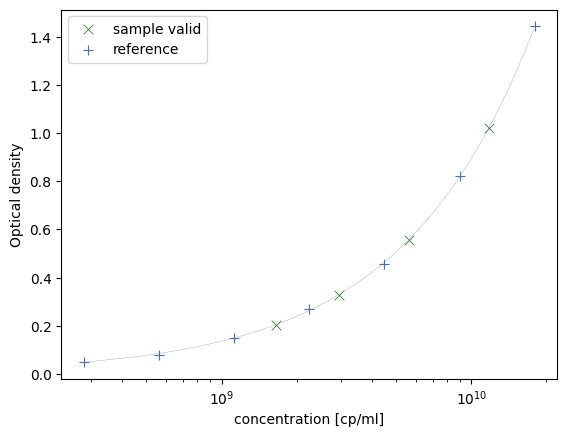

In [42]:
def mask_index(df):
    b = df.reset_index(level=[0,1])
    b = b[b['mask_reason'].notna()]

    return b.index


def na_index(df):
    b = df.reset_index(level=[0,1])
    b = b[b['backfit'].isna()]
    
    return b.index


def sample_img(samples, sample_type, sample_num, img_file=None, show=True, verbose=False):
    sd = sample_check(samplesk, sample_type, sample_num)
    if verbose:
        print(sample_type, sample_num)
        display(sd['sample'])

    mask_idx = mask_index(sd['sample'])
    x = ref.reset_index(level=[0,1])['plate_layout_dil']
    y = ref.reset_index(level=[0,1])['OD_delta']
    fit_result = fit_reference_auto_rm(x, y, verbose=verbose)
    # compute original concenmtration 
    sd['sample'].loc[:, ['conc_plot']] = sd['sample'].apply(lambda x: x['concentration'] / x['plate_layout_dil'], axis=1)
    sx = sd['sample'].reset_index(level=[0,1])['conc_plot']
    sy = sd['sample'].reset_index(level=[0,1])['OD_delta']
    fit_image(x, y, fit_result[0][0], fit_result[0][1], img_file, confidence='student-t',
              rm_index=fit_result[1], mask_index=mask_idx,
              sx=sx, sy=sy, sna_idx=na_index(sd['sample']), show=show, valid_sample=sd['valid'], interval_ratio=1.0)
    # display(na_index(sd['sample']))
    
sample_img(samplesk, 's', 6)

## Worklist

In [43]:
def check_worklist(wl):
    valid_plates = []
    for i in range(1, 4):
        invalid_sample = wl['SampleID_{}'.format(i)].isnull().values.any()
        if not invalid_sample: valid_plates.append(i)
    return valid_plates


def read_worklist(worklist_file):
    wl = pd.read_excel(worklist_file)
    wl.set_index([['control 01', 'reference 01', 'blank', 'sample 01', 'sample 02', 'sample 03',
        'sample 04', 'sample 05', 'sample 06', 'sample 07', 'sample 08', 'sample 09', 'sample 10',
        'sample 11', 'sample 12', 'sample 13', 'sample 14', 'sample 15', 'sample 16', 'sample 17',
        'sample 18', 'sample 19', 'sample 20', 'sample 21']], inplace=True)
    check_worklist(wl)
    wl.drop('blank', axis=0, inplace=True)
    wl.index.name = 'Sample type'

    return wl


def worklist_sample(wl, plate_id):
    invalid_sample = wl['SampleID_{}'.format(plate_id)].isnull().values.any()
    if invalid_sample:
        return None, None
    
    cols_id =['SampleID', 'Dilution', 'Viscosity']
    cols = [x + '_' + str(plate_id) for x in cols_id]
    cols_dict = {x : y for x,y in zip(cols_id, cols)}

    return wl[cols], cols_dict


wl_raw = read_worklist(WORKLIST_FILE_PATH)
valid_plates = check_worklist(wl_raw)
wl, wl_cols_dict = worklist_sample(wl_raw, PLATE_ID)

In [44]:
def final_sample_info(all_info, pre_dilution, verbose=False):
    info = all_info['info']
    if not all_info: raise Exception("Invalid sample info!")
    if not info:
        return '', True
    
    msg = ''
    valid_ex = False
    if info['enum'] == SampleInfo.NAN_HIGH:
        msg = '>{:.4e}'.format(info['value'] * pre_dilution)
    elif info['enum'] == SampleInfo.NAN_LOW:
        valid_ex = True
        msg = '<{:.4e}'.format(info['value'] * pre_dilution)
    elif info['enum'] == SampleInfo.HIGH:
        msg = '>{:.4e}'.format(info['value'] * pre_dilution)
    elif info['enum'] == SampleInfo.LOW:
        msg = '<{:.4e}'.format(info['value'] * pre_dilution)
        valid_ex = True
    elif info['enum'] == SampleInfo.VALID_PTS:
        msg = '{} valid point'.format(all_info['valid_pts'])
    elif info['enum'] == SampleInfo.CV:
        msg = 'CV>{:.2f}%({:.2f}%)'.format(CV_THRESHOLD * 100.0, info['value'] * 100.0)
    else:
        msg = ''
        valid_ex = True

    return msg, valid_ex

In [45]:
# TODO: nasty, using globals!!!
def make_final():
    final = pd.concat([wl, sl], axis=1)
    cd = wl_cols_dict
    final.loc[:, ['Result [cp/ml]']] = final.apply(lambda x: x['Reader Data [cp/ml]'] * x[cd['Dilution']], axis=1)
    final.loc[:, ['CV [%]']] = final.apply(lambda x: x['CV [%]'] * 100, axis=1)
    # reorder columns
    final = final.reindex([cd['SampleID'], cd['Dilution'], cd['Viscosity'], 'Reader Data [cp/ml]', 'Result [cp/ml]', 'CV [%]', 'Valid', 'info'], axis=1)
    final.rename(columns={cd['SampleID']: 'Sample Name', cd['Dilution']: 'Pre-dilution'}, inplace=True)
    final.drop('Viscosity_{}'.format(PLATE_ID), axis=1, inplace=True)
    final.index.name = 'Sample type'
    final.loc[:, ['info_ex']] = final.apply(lambda x: final_sample_info(x['info'], x['Pre-dilution'])[0], axis=1)
    final.loc[:, ['valid_ex']] = final.apply(lambda x: final_sample_info(x['info'], x['Pre-dilution'])[1], axis=1)
    return final

# final = make_final()
# final

In [46]:
final = make_final()
final

,Sample Name,Pre-dilution,Reader Data [cp/ml],Result [cp/ml],CV [%],Valid,info,info_ex,valid_ex
Sample type,,,,,,,,,
control 01,Kontrolle01,1,2.070504e+10,2.070504e+10,12.233499,True,"{'cv': 0.12233498999624857, 'mean': 2070504311...",,True
reference 01,Referenz01,1,1.793872e+10,1.793872e+10,3.689750,True,"{'cv': 0.03689750273529114, 'mean': 1793872467...",,True
sample 01,PPO02_2307HAR_MEG_Z2,100,6.371664e+09,6.371664e+11,3.806914,True,"{'cv': 0.03806914185628799, 'mean': 6371664393...",,True
sample 02,PPO02_2307HAR_MEG_Z3,100,6.874514e+09,6.874514e+11,9.650644,True,"{'cv': 0.0965064358325309, 'mean': 6874513529....",,True
sample 03,PPO02_2307HAR_MEG_Z4,100,7.422786e+09,7.422786e+11,4.114851,True,"{'cv': 0.041148507573073, 'mean': 7422786325.6...",,True
sample 04,PPO02_2307HAR_ECV_P,50,1.259287e+10,6.296433e+11,3.098899,True,"{'cv': 0.030988985874233915, 'mean': 125928656...",,True
sample 05,PPO02_2307_UFA_UF1_R,500,2.666918e+10,1.333459e+13,5.873502,True,"{'cv': 0.05873502230641727, 'mean': 2666918232...",,True
sample 06,PPO02_2307_UFA_Pool,1000,1.201651e+10,1.201651e+13,7.169307,True,"{'cv': 0.07169306516545661, 'mean': 1201651427...",,True
sample 07,PPO02_2307_UCE_P,500,6.684402e+10,3.342201e+13,6.592012,True,"{'cv': 0.0659201160508753, 'mean': 66844024746...",,True


## Plate Layout

In [47]:
df = plate_layout_num.replace({'b':-99}).astype(float)
df

,1,2,3,4,5,6,7,8,9,10,11,12
A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
B,1.0,1.0,1.0,1.0,8.0,8.0,8.0,8.0,15.0,15.0,15.0,15.0
C,2.0,2.0,2.0,2.0,9.0,9.0,9.0,9.0,16.0,16.0,16.0,16.0
D,3.0,3.0,3.0,3.0,10.0,10.0,10.0,10.0,17.0,17.0,17.0,17.0
E,4.0,4.0,4.0,4.0,11.0,11.0,11.0,11.0,18.0,18.0,18.0,18.0
F,5.0,5.0,5.0,5.0,12.0,12.0,12.0,12.0,19.0,19.0,19.0,19.0
G,6.0,6.0,6.0,6.0,13.0,13.0,13.0,13.0,20.0,20.0,20.0,20.0
H,7.0,7.0,7.0,7.0,14.0,14.0,14.0,14.0,21.0,21.0,21.0,21.0


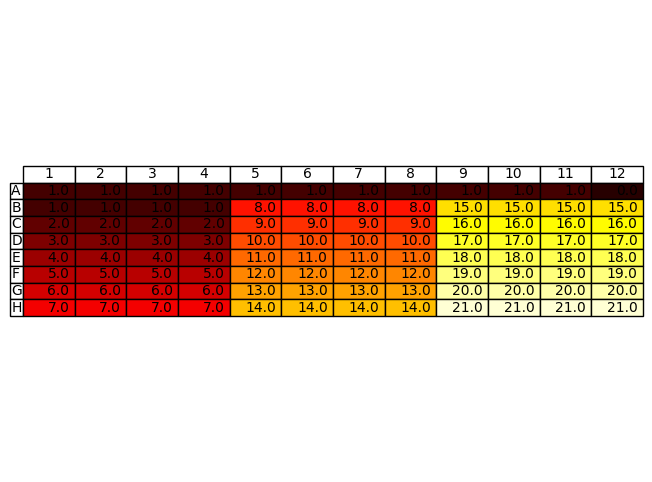

In [48]:
from matplotlib import pyplot as plt

vals = np.around(df.values, 2)
norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.hot(norm(vals))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    loc='center', cellColours=colours)
plt.show()

## Report  
We build a report here...

### Fit Reference Curve

In [49]:
def fit_section_md(df_ref, popt, pcov, out_dir):
    x = df_ref.reset_index(level=[0,1])['plate_layout_dil']
    y = df_ref.reset_index(level=[0,1])['OD_delta']
    fit_result = fit_reference_auto_rm(x, y)
    result_img = path.join(out_dir, 'fit.png')
    fit_image(x, y, fit_result[0][0], fit_result[0][1], result_img, confidence='student-t', rm_index=fit_result[1])
 
    n = len(x) - len(fit_result[1])
    df_fit = fit_sheet(popt, pcov, n)
    display(df_fit)

    md = '## Reference Curve Fit\n\n'
    md += '$\LARGE y = {d + {a - d \over {1 + ({ x \over c })^b}} }$  \n\n'
    md += '!["alt text"](./img/fit.png)'

    md += '\n\n'
    md += 'Verbose fitting progress, metric is R-squared:\n\n'
    md += fit_result[3].to_markdown() + '\n\n'

    md += 'Fit parameters\n\n'
    md += df_fit.to_markdown(index=False) + '\n\n'
    md += 'Backfit...'
    fit_result = fit_reference_auto_rm(x, y)
    df_backfit = backfit(df_ref, fit_result[0][0])
    md += '\n\n' + df_backfit.to_markdown() + '\n\n'

    # cv = variation(df_backfit['concentration'], ddof=1)

    return md

# fit_section_md(ref, popt, pcov, REPORT_DIR)

### Sample

In [50]:
def sample_to_md(dc):
    s_view = dc['sample'][['OD_delta', 'plate_layout_dil', 'concentration', 'mask_reason']]
    md = "### Sample: {0} '{1}' {2}\n\n".format(SAMPLE_TYPES[dc['type']], dc['type'], dc['num'])
    md += s_view.to_markdown()
    md += '\n\n'
    md += "CV = {:2.3} [%]  \n".format(100 * dc['cv'])
    md += "mean = {:.4} [cp/ml]  \n".format(dc['mean'])
    md += "valid = {}  \n".format(dc['valid'])
    if dc['note']:
         md += "note: {}  ".format(dc['note'])

    return md

def sample_section_md(samples, img_dir):
    md = '## Sample evaluation\n\n' 
    k = sample_check(samples, 'k', 1)
    md += sample_to_md(k)
    sfile = 'control_{0:02d}.png'.format(1)
    img_file = path.join(img_dir, sfile)
    sample_img(samples, 'k', 1, img_file, show=False)
    md += '!["alt text"](./img/{})\n\n'.format(sfile)
    sample_n = samples['plate_layout_num'].astype(int).unique()
    sample_n.sort()
    for i in sample_n:
        stype = 's'
        s = sample_check(samples, stype, i)
        md += sample_to_md(s)
        # sample info
        si = sample_info(samples, stype, i, verbose=False)
        si_str = sampleinfo_to_str(si['info'])
        if si_str:
            md += '\n'
            md += 'info: ' + si_str + '  '
        md += '\n'
        sfile = 'sample_{0:02d}.png'.format(i)
        img_file = path.join(img_dir, sfile)
        sample_img(samples, stype, i, img_file=img_file, show=False, verbose=False)
        md += '![{0}](./img/{0})\n\n'.format(sfile)
    return md

def save_md(file_path, md_txt):
    try:
        with open(file_path, 'w') as fl:
            fl.write(md_txt)
    except Exception as e:
        print('Error: ' + str(e))

### Results

In [51]:
final_result = make_final()

def format_resluts_val(x):
    res = ''
    if math.isnan(x['Result [cp/ml]']):
        res = x['Comment']
    else:
        res = '{:.4e}'.format(x['Result [cp/ml]'])
    if x['valid_ex']:
        res = '**{}**'.format(res)
    else:
        res = '( {} )*'.format(res)
    
    return res

def format_results(df):
    df.loc[:, ['Comment']] = df.apply(lambda x: final_sample_info(x['info'], x['Pre-dilution'])[0], axis=1)
    df.loc[:, ['CV [%]']] = df.apply(lambda x:'{:.2f}'.format(x['CV [%]']), axis=1)
    # df.loc[:, ['Result [cp/ml]']] = df.apply(lambda x: x['Comment'] if math.isnan(x['Result [cp/ml]']) else '{:.4e}'.format(x['Result [cp/ml]']), axis=1)
    # display(df)
    df.loc[:, ['Result [cp/ml]']] = df.apply(lambda x: format_resluts_val(x), axis=1)
    df.drop(['info', 'Valid', 'Reader Data [cp/ml]', 'info_ex', 'valid_ex'], axis=1, inplace=True)
    
    return df

# format_results(final_result)
# final_result

In [52]:
def result_section(df):
    md = '## Analysis Results\n\n'

    md += format_results(df).to_markdown()
    md += '\n\n'
    
    return md


### Header

In [53]:
def header_section(date, id, plate_id, msg):
    md =  '## Header\n\n'

    md += 'Date: {}\n\n'.format(date)
    md += 'Identification: {}\n\n'.format(id)
    md += 'Plate: {}\n\n'.format(plate_id)
    md += 'Comment: {}\n\n'.format(msg)

    return md;

### Parameters

In [54]:
def param_section(df_params):
    md =  '## Parameters\n\n'

    md += 'Parameters:\n\n' + df_params.to_markdown() + '\n\n'

    return md;

In [55]:
final_result

,Sample Name,Pre-dilution,Reader Data [cp/ml],Result [cp/ml],CV [%],Valid,info,info_ex,valid_ex
Sample type,,,,,,,,,
control 01,Kontrolle01,1,2.070504e+10,2.070504e+10,12.233499,True,"{'cv': 0.12233498999624857, 'mean': 2070504311...",,True
reference 01,Referenz01,1,1.793872e+10,1.793872e+10,3.689750,True,"{'cv': 0.03689750273529114, 'mean': 1793872467...",,True
sample 01,PPO02_2307HAR_MEG_Z2,100,6.371664e+09,6.371664e+11,3.806914,True,"{'cv': 0.03806914185628799, 'mean': 6371664393...",,True
sample 02,PPO02_2307HAR_MEG_Z3,100,6.874514e+09,6.874514e+11,9.650644,True,"{'cv': 0.0965064358325309, 'mean': 6874513529....",,True
sample 03,PPO02_2307HAR_MEG_Z4,100,7.422786e+09,7.422786e+11,4.114851,True,"{'cv': 0.041148507573073, 'mean': 7422786325.6...",,True
sample 04,PPO02_2307HAR_ECV_P,50,1.259287e+10,6.296433e+11,3.098899,True,"{'cv': 0.030988985874233915, 'mean': 125928656...",,True
sample 05,PPO02_2307_UFA_UF1_R,500,2.666918e+10,1.333459e+13,5.873502,True,"{'cv': 0.05873502230641727, 'mean': 2666918232...",,True
sample 06,PPO02_2307_UFA_Pool,1000,1.201651e+10,1.201651e+13,7.169307,True,"{'cv': 0.07169306516545661, 'mean': 1201651427...",,True
sample 07,PPO02_2307_UCE_P,500,6.684402e+10,3.342201e+13,6.592012,True,"{'cv': 0.0659201160508753, 'mean': 66844024746...",,True


### Report Assembly

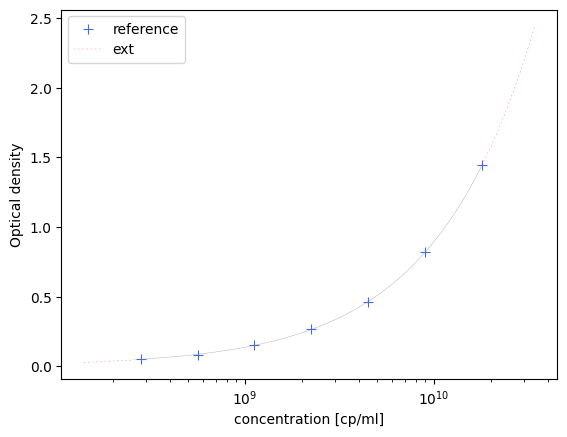

,Parameter name,Estimated value,Error,Confidence interval
0,a,4.280025e-04,1.001008e-02,"[-0.0314, 0.0323]"
1,b,8.193470e-01,5.236953e-02,"[0.653, 0.986]"
2,c,5.482125e+13,4.116390e+15,"[-1.3e+16, 1.32e+16]"
3,d,1.035806e+03,6.322046e+04,"[-2e+05, 2.02e+05]"


./data/input/results_2\230426_GN004240-033_-_report_2.md


<Figure size 640x480 with 0 Axes>

In [56]:
report = '''
# Automatically Generated Markdown report

This a PoC for automatic report generation...  

'''

report += header_section('05 May 2023', 'GN004240-033', PLATE_ID, ':)')
report += result_section(final_result.drop('reference 01', axis=0))
report += param_section(params)
img_dir = path.join(REPORT_DIR, 'img')
os.makedirs(img_dir, exist_ok=True)
report += fit_section_md(ref, popt, pcov, img_dir) # TODO: !!! global fit_result[3]

report += sample_section_md(samplesk, img_dir)

print(REPORT_FILE_PATH)
save_md(REPORT_FILE_PATH, report)

In [57]:
# from Markdown2docx import Markdown2docx
# report_path_noext = os.path.abspath(os.path.splitext(REPORT_FILE_PATH)[0])
# print(report_path_noext)
# project = Markdown2docx(report_path_noext)
# # project = Markdown2docx('data/input/results_2/aaa')
# project.eat_soup()
# project.save()

### Export to PDF

In [58]:
from md2pdf.core import md2pdf
PDF_FILE_PATH = path.join(REPORT_DIR,"{}.pdf".format(os.path.basename(REPORT_FILE_PATH)))

In [59]:
md2pdf(PDF_FILE_PATH,
       md_content=report,
       md_file_path=None,
       css_file_path=None,
       base_url=None)